# How did Lockdown changed crime patterns in certain areas of Greater London?

## Introduction

In december of 2019 the first case of a disease involving a 'strange pneumonia' (named later SARS-CoV-2) was detected in Wuhan, China. Though there were some worried voices about the detection of a new unknown disease, comparisons to past epidemics such as the H1N1 and the SARS-MERS brought comfort to leaders and were used to soothe the public opinion. As time passed, scientists started to learn more about this new disease and due to its high transmisibility it soon became clear that there was no point of comparison between the new virus and the ones before it. 

By march 2020 the World Health Organization raised the alarms and declared a global pandemic. It became clear that the virus had spread faster and farther than anyone could have imagined and it was evident that decisions to put a brake on the spread were being taken too late. Leaders in Europe realized the magnitude of what they were facing and promptly decided to impose strict lockdown measures even if that meant shutting down the global economy.

![caption](Covid.jpg)

After looking at the advances of the virus in it's neighboring countries, the government of UK also decided to act. The 20th of march it was announced that all public venues had to close. This measure applied to pubs, restaurants, gyms, nightclubs, theatres and cinemas. Schools and universities were also included. Three days later it was stated on a television broadcast that a general order to stay at home was inplace and that restrictions on the freedom of movement were going to be enforced by the law. British residents were adviced to stay home throughout this period except for essential purchases, essential work travel (if possible remote work had to be done), medical needs, and providing care for others. These restrictions were eased during late may and june when students were allowed to return to schools and some non essential retailers as well as public venues were allowed to start opening again. 

The introduction of the lockdown had an immense effect on London. The center of the city that used to be full of tourists, public venues, social life and a vast amount of commuters had now turned to a rather lonesome place. As the inflow of tourists was severely hindered, non essential retail shops closed and commuters started to work remotely several changes in the city started to manifest. 

In this notebook I present an exploratory analysis based on data at the crime event level to answer whether there was any change in the geographic distribution of crime in the greater City of London and in it's composition when Pre Lockdown, Lockdown and Post Lockdown times are compared.

## Description of the data

The analysis is based on several sources of data. The main dataset is obtained through the custom download tool provided in the [Police Data](https://data.police.uk/data/) web page it provides street-level crime and outcomes, broken down by police force and 2011 lower layer super output area (LSOA). We consider the crime data involving both the *City Of London Police* as well as the *Metropolitan Police Service*. The period chosen spans from January to September of 2020, based on the rigor of the lockdown measures imposed I categorize the first quarter of the year as Pre Lockdown times, the second quarter as Lockdown and the third one as Post Lockdown. 

The information is complemented through geographical data for the LSOA, MSOA (middle super output area) and the London Boroughs. This data is taken from the London Data Store [Statistical GIS Boundaries](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london). It contains several shape files that delimit the boundaries of LSOAs, MSOAs and Boroughs in the greater London Area. 

Finally, I also consider data obtained through the use of the [Police API](https://data.police.uk/docs/) regarding the number of stop and search procedures carried out by the two police forces mentioned above during the first three quarters of 2020. 

All codes used to obtain the main dataset and the API information are included in the notebook **Dataset.ipynb**. The API data obtained consists of the counts of stop (and possibly search) procedures made on the street by police officers in each of the MSOA's composing the Greater London Area by different age groups. The requests are made through the requests module in Python and results are directly parsed from the response JSON. 


## Research Question

I am interested in answering the following questions:

- Was criminal activity modified by the introduction of the Lockdown measures in the greater Area of London?
- Did crime composition changed when comparing Pre Lockdown, Lockdown and Post Lockdown times in the greater Area of London? Were there any changes in frisking procedures done during these periods?
- In case there was a change in criminal activity dynamics, was there any specific pattern in the geographical distribution of crime?

An interesting topic I want to address in the last part is to characterize if there exist any associations between types of crimes that ocurred in certain geographical aggregations and the Pre Lockdown, Lockdown and Post Lockdown periods. 

## Data Cleaning

After gathering the data from the different monthly files obtained by each police force, I carried out some brief data cleaning steps.

In [1]:
## Initial Cleaning
import pandas as pd
import numpy as np

## Read data 
data = pd.read_csv("Data/DataProject.csv")

In [2]:
## Columns
print(list(data.columns))
## Number of observations
print("Number of observations: " + str(data.shape[0]))
## Head
data.head()

['Unnamed: 0', 'Month', 'Longitude', 'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type', 'Last outcome category', 'Id']
Number of observations: 897349


,Unnamed: 0,Month,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Id
0,0,1,-0.106453,51.518207,City of London,E01000916,Camden 027B,Theft from the person,Investigation complete; no suspect identified,0
1,1,1,-0.117684,51.522003,City of London,E01000920,Camden 027D,Drugs,Court result unavailable,1
2,2,1,-0.111497,51.518226,City of London,E01000914,Camden 028B,Other theft,Unable to prosecute suspect,2
3,3,1,-0.111962,51.518494,City of London,E01000914,Camden 028B,Other theft,Investigation complete; no suspect identified,3
4,4,1,-0.113256,51.516824,City of London,E01000914,Camden 028B,Other theft,Investigation complete; no suspect identified,4


Both the *id* and the *Unnamed:0* columns have to be dropped as they don't contain useful information (were mostly used as identifiers in the raw data). Also some renaming of the columns is made to make working with them easier. 

The raw data only has missing values in the *Last Outcome Category* variable, however this is merely used to denote that there was no outcome regarding the crime. It turns out that the missing value is in fact only used to denote the *Category* of the Crime *Anti-social behaviour*. So we can just complete it.

In [3]:
## Information on data
data.info()

## Drop Id columns (repeated)
data.drop(["Id","Unnamed: 0"],axis=1,inplace=True)

## Rename Columns
data.rename({"Crime type":"Crime", "Last outcome category":"Category"},axis=1,
            inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897349 entries, 0 to 897348
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             897349 non-null  int64  
 1   Month                  897349 non-null  int64  
 2   Longitude              897349 non-null  float64
 3   Latitude               897349 non-null  float64
 4   Location               897349 non-null  object 
 5   LSOA code              897349 non-null  object 
 6   LSOA name              897349 non-null  object 
 7   Crime type             897349 non-null  object 
 8   Last outcome category  576260 non-null  object 
 9   Id                     897349 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 68.5+ MB


In [4]:
## Handling of missing values
# Note that missing in Category means that there was no outcome is used only 
## for Anti-social behaviour
print(data[data.Category.isnull()]["Crime"].value_counts())
## Counts of unique values per crime
bfill = data.groupby("Crime").Category.nunique()
## Fill
data.fillna("No further investigation",inplace=True)

Anti-social behaviour    321089
Name: Crime, dtype: int64


In [5]:
## Check filled missing values by group  before|after
afill = data.groupby("Crime").Category.nunique()
check = pd.merge(bfill.reset_index(),afill,on="Crime")
check

,Crime,Category_x,Category_y
0,Anti-social behaviour,0,1
1,Bicycle theft,8,8
2,Burglary,12,12
3,Criminal damage and arson,11,11
4,Drugs,12,12
5,Other crime,10,10
6,Other theft,11,11
7,Possession of weapons,11,11
8,Public order,12,12
9,Robbery,9,9


I also generate the variable that is going to be used to identify the three periods of interest Pre Lockdown, Lockdown and Post Lockdown. All text variables that represent Categories are reconverted to categorical. The *Covid* variable is reordered as in the real ocurrence of events and the categories of the variable related to the police force involved *Location* are recoded. Note that the *Location* name is rather an identifier of the police force.

In [6]:
## Create Lockdown variable
conds = [data.Month.lt(4), data.Month.lt(7), data.Month.lt(10)]
data['Covid'] = np.select(conds, ["PreLockdown","Lockdown","PostLockdown"])

## Replace Month with complete Date
data['Date'] = pd.to_datetime(["2020-" + str(x) + "-01" for x in data.Month])

## Convert categorical variables to category
for col in ['Location', 'LSOA name','Crime', 'Category', 'Covid']:
    data[col] = data[col].astype('category')

## Reorder|Rename categories
data['Covid'].cat.reorder_categories(['PreLockdown', 'Lockdown', 'PostLockdown'], 
                                     inplace=True)
data['Location'].cat.rename_categories({'City of London ':'City of London',
                                    'Metropolitan  Service':'Metropolitan Service'},
                                       inplace=True)

Finally, *Crimes* with counts below 10.000 are dumped into the Other crime category and results are saved in a pickle file.

In [7]:
data['Crime'].value_counts()

Anti-social behaviour           321089
Violence and sexual offences    170308
Vehicle crime                    80685
Other theft                      62788
Burglary                         45472
Public order                     40618
Drugs                            39495
Criminal damage and arson        38346
Shoplifting                      26305
Theft from the person            22206
Robbery                          20357
Bicycle theft                    17777
Other crime                       7533
Possession of weapons             4370
Name: Crime, dtype: int64

In [8]:
## Lump low counts (Weapon Possesion)
need = data['Crime'].value_counts().index[-1:-3:-1] 
data['Crime'] = np.where(~data['Crime'].isin(need), data['Crime'], 'Other crime')

In [9]:
## Delete non-using variables
del bfill, afill, check, conds, need

## Save to pickle 
#pickle.dump(data, open("Data/DataClean.p", "wb"))

## Data Analysis

### Introduction

We start by loading in the already cleaned data from the section above. First thing to notice is that we have 6245 distinct LSOA's and all of these appear in the Metropolitan Service force records. 

The so called *location* variable doesn't represent location but rather the police force that attended the crime. There is an overlap in certain LSOA's for which both the Metropolitan Service and the City of London Police can be in charge of the criminal investigation. The overlap is mainly in the centre of the city (what Londoners know as Zone 1).

In [1]:
## Modules
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import re
import geopandas as gpd
import plotly.express as px


In [11]:
##--------------------------------------------------------------##
## Load Data 
data = pickle.load(open("Data/DataClean.p", "rb" ) )

## Total Number of LSOAs
print("Total number of LSOAS: " + str(len(data['LSOA name'].unique())))
## Total Number of LSOAS by Location
print(data.groupby('Location')['LSOA name'].nunique())
## Attended by City of London Force
print("Attended by City of London police: \n")
print(data[data.Location=="City of London"]["LSOA name"].unique())

Total number of LSOAS: 6245
Location
City of London            46
Metropolitan Service    6245
Name: LSOA name, dtype: int64
Attended by City of London police: 

['Camden 027B', 'Camden 027D', 'Camden 028B', 'City of London 001A', 'City of London 001B', ..., 'Southwark 002A', 'Southwark 003H', 'Tower Hamlets 021D', 'Hackney 003C', 'Tower Hamlets 007C']
Length: 46
Categories (46, object): ['Camden 027B', 'Camden 027D', 'Camden 028B', 'City of London 001A', ..., 'Southwark 003H', 'Tower Hamlets 021D', 'Hackney 003C', 'Tower Hamlets 007C']


In the already cleaned dataset we have 13 different categories of crime types and  15 different outcomes related with these categories. I decided not to lump the low counts in the outcomes variable since the analysis is not going to focus that much in this variable but rather in the types of crime and its comparisons through the quarters of the year. 

In [12]:
## Unique values of Crime 
data.Crime.value_counts()

Anti-social behaviour           321089
Violence and sexual offences    170308
Vehicle crime                    80685
Other theft                      62788
Burglary                         45472
Public order                     40618
Drugs                            39495
Criminal damage and arson        38346
Shoplifting                      26305
Theft from the person            22206
Robbery                          20357
Bicycle theft                    17777
Other crime                      11903
Name: Crime, dtype: int64

In [13]:
## Unique values of Category
data.Category.value_counts()

Investigation complete; no suspect identified          374510
No further investigation                               321089
Status update unavailable                               78385
Under investigation                                     61111
Awaiting court outcome                                  22881
Local resolution                                        22253
Court result unavailable                                 6672
Offender given penalty notice                            5395
Offender given a caution                                 4299
Offender given a drugs possession warning                 358
Unable to prosecute suspect                               289
Formal action is not in the public interest                53
Further investigation is not in the public interest        40
Action to be taken by another organisation                 11
Suspect charged as part of another case                     3
Name: Category, dtype: int64

### Evolution of aggregated counts by Police force through the year

To start the analysis its important to consider how the aggregated counts of crime evolved through the year. I present the dynamics of these counts separated by police force involved and considering the aggregate. Data are aggregated for all LSOA's. 

In [14]:
data_agg = data[['Date','Location','Crime', 'Category']]. \
            groupby(['Date','Location', 'Crime']).count(). \
                fillna(0)
data_agg.reset_index(inplace=True)
data_agg.rename({'Category':'Sum'}, axis=1, inplace = True)
data_agg['Date']=data_agg['Date'].dt.strftime('%B')

data_agg2 = data_agg.groupby(["Date", "Crime"]).sum().reset_index()
data_agg2['Location'] = 'Aggregate'
data_agg = pd.concat([data_agg,data_agg2])
data_agg['Date'] = data_agg['Date'].astype("category")
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
          'August', 'September']
data_agg['Date'] = data_agg['Date'].cat.reorder_categories(months)

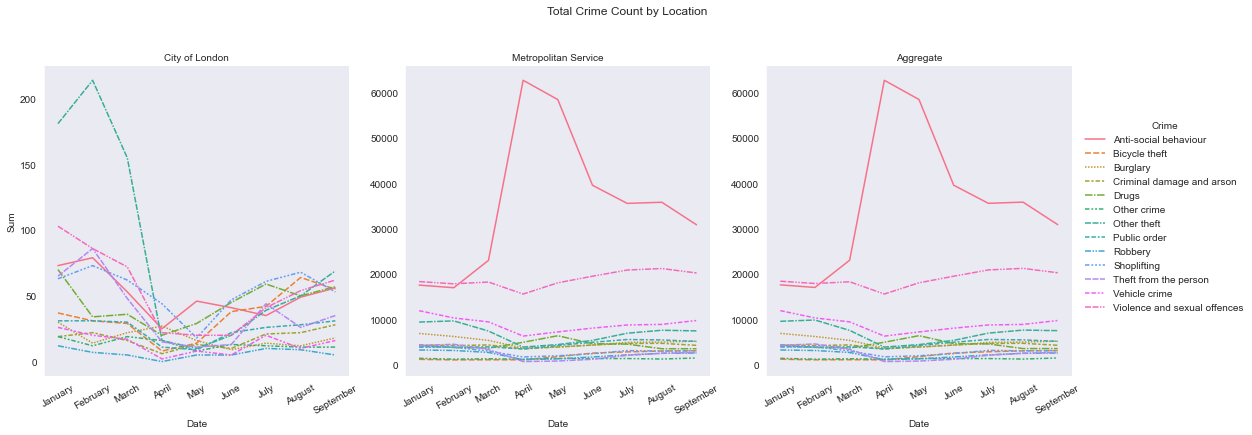

In [15]:
## Total counts showing number of crimes by type and force
sns.set_style("dark")
sns.set_palette("bright")
p_1 = sns.relplot(x='Date',y='Sum', hue="Crime", 
                  data=data_agg,kind='line',col='Location',
                  style = 'Crime',
                  facet_kws={'sharey': False, 'sharex': True})
p_1.set_xticklabels(rotation=30)
p_1.fig.suptitle("Total Crime Counts by Police Force Involved", y = 1.1)
p_1.set_titles("{col_name}")
p_1

Several patterns emerge. 
- Crime counts for *Other Theft* (which is mainly what the City of London police force used to attend) significantly dropped after the Lockdown was imposed on march. This is expected as the inflow of people and tourists to the center of the city significantly decreased due to the mobility restrictions and the work-at-home orders. 
- There was a sharp increase in cases of *Anti-social behaviour* during the Lockdown period that were attended maninly by the Metropolitan Service. The counts decreased when the Lockdown period was over but remained well above their number in the PreLockdown period. 
- Overall the most frequent crime is *Anti-social behaviour* and it accounts for a very high proportion of the total crimes commited during 2020. 
- The number of cases attended by the Metropolitan Service and the City Of London police force differ in several orders of magnitude. So the aggregate of the Greater London Area mirrors more the Metropolitan Service force records. 


### Evolution of aggregated counts by crime type through the year

In order to get a better sense of the changes in crime counts by month I exclude the category of *Anti-social behaviour* because it generates a large imbalance in the counts. Later I show a barplot in which this category is included but using a logarithmic transformation. 

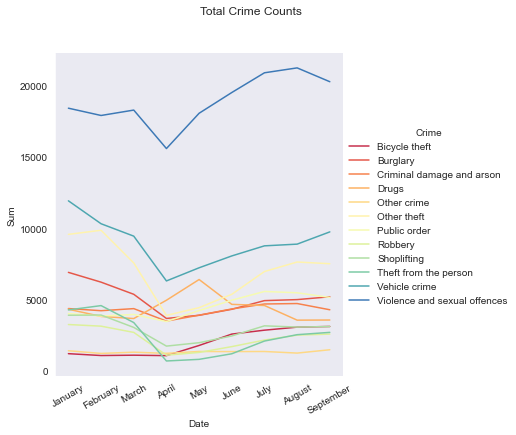

In [16]:
## Aggregate counts excluding Anti social behavior 
data_focus = data_agg[(data_agg.Location == "Aggregate") & 
         (data_agg.Crime != "Anti-social behaviour")]
p1_a = sns.relplot(x = "Date", y = "Sum", hue = "Crime",
             data=data_focus, kind = "line", palette = "Spectral")
p1_a.set_xticklabels(rotation=30)
p1_a.fig.suptitle("Total Crime Counts by Crime Type", y = 1.1)
p1_a

- As we can see, the period of Lockdown reflected in a decrease in almost all types of crime. Except for *Bicycle theft* and *Drugs*. During this period the total cases of the former increased slightly while for the latter there was a significant increase in april and may. 

- The sharpest decreases during Lockdown were seen in *Theft from the person* and *Other theft*. Though there was also a slight decrease in *Violence and sexual offences*. All in all crimes that were related to the flow of people into the city such as almost all forms of theft/robbery decreased in response to the strict lockdown measures. 

- The PostLockdown period was characterized by a notorious increase in crimes related to *Violence and sexual offences* way above their PreLockdown level. In general all other crimes seemed to revert to Pre Lockdown levels too, except for the *Bicycle theft* which kept increasing.  

All of these facts are easily seen in the figure below where I plot total crime counts using a logarithmic transformation so as to take into account the notorious difference of counts by type.

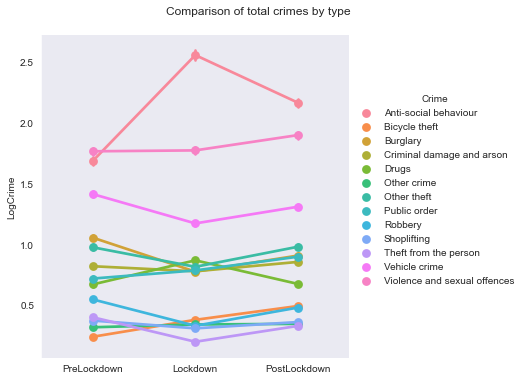

In [17]:
## Total crimes by type comparing quarters
data_agg = data[["LSOA name", "Covid", "Crime", "Category"]].groupby(["LSOA name", "Covid", "Crime"]).count().fillna(0)
data_agg['LogCrime'] = np.log(data_agg['Category']+1)
data_agg.reset_index(inplace=True)
## By crime type means
p_4 = sns.catplot(x="Covid",y="LogCrime", hue="Crime", kind="point",
            data=data_agg)
p_4.fig.suptitle("Comparison of LogCrimes by Type", y = 1.05)
p_4.set(xlabel="")

### Distribution of crime counts by LSOA 

While it is true that there are several interesting behaviours in the aggregated data for the Greater London Area there's also a lot of variation in the data at the LSOA level. In this section I explore a little more the results for this geographical disaggregation. 

Results are shown using a log transformation over the counts due to the highly skewed distribution of total crimes by location.

In [18]:
data_agg = data[["LSOA name", "Covid", "Crime", "Location"]] \
    .groupby(["LSOA name", "Covid", "Location"]).count()
data_agg.fillna(0,inplace=True)
data_agg.reset_index(inplace=True)

## Crime counts are highly skewed by LSOA 
data_agg['Crime'].describe()

count    37470.000000
mean        23.948465
std         51.203699
min          0.000000
25%          0.000000
50%          0.000000
75%         37.000000
max       2271.000000
Name: Crime, dtype: float64

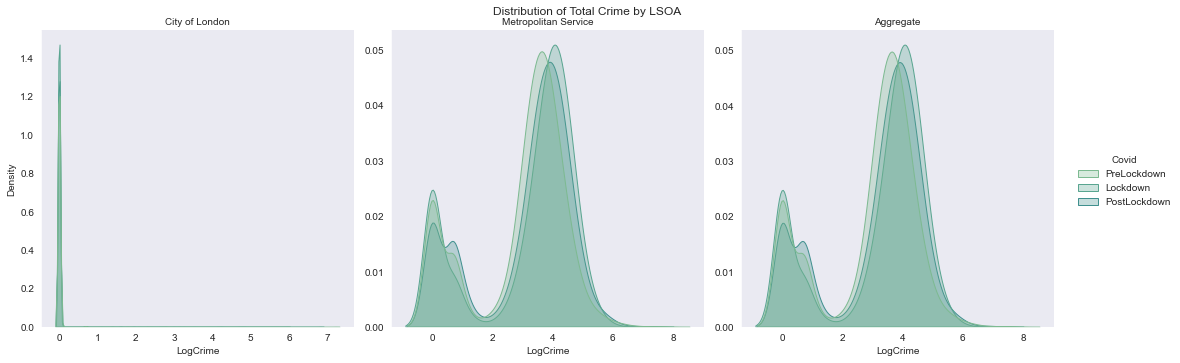

In [19]:
## Using logarithm 
data_agg['LogCrime'] = np.log(data_agg['Crime']+1)

## Aggregate (both Police Forces)
data_agg2 = data_agg.groupby(["LSOA name","Covid"]).sum().reset_index() 
data_agg2["LogCrime"] =  np.log(data_agg2['Crime']+1)
data_agg2['Location'] = 'Aggregate'
data_agg = pd.concat([data_agg,data_agg2])

## Density plot
sns.set_palette("crest")
p_2 = sns.displot(x="LogCrime",data=data_agg,hue="Covid",alpha=0.3,
            kind="kde",fill=True, col="Location", facet_kws={'sharey': False, 'sharex': False})
p_2.fig.suptitle("Distribution of Total Crime by LSOA",y=1)
p_2.set_titles("{col_name}")

The highly skewed distribution observed for the observations regarding the City Of London force (even in logarithm) reflects the fact that most of the crime that this force responds to is located in a couple of LSOA's. By checking the data we note that most of the crime counts in this case happen in the LSOA's *City of London 001F* and *City of London 001G*. The first one includes tube stations such as **Bank** and **Liverpool Street** while the second is closer to the **BlackFriars** station. Except for these two aggregates the other locations have a relatively low count of crime cases. 

The aggregate distribution closely mirrors the one of the Metropolitan Service this happens again because the high proportion of crime cases that this force has to respond to. The aggregate distribution is bimodal suggesting two types of LSOA's some with very low crime counts and others with a relatively more moderate number of ocurrences. 

Overall the second mode of the distribution shifted when comparing the Pre Lockdown, Lockdown and Post Lockdown scenarios. It seems that all in all crime in LSOA's with a low to moderate number of ocurrences increased during the Lockdown and increased further in Post Lockdown when comparing with the results of the first quarter. This fact is probably related with the huge increase in *Anti-social behaviour* crimes ocurred during the first nine months of 2020. 

In [20]:
## Check Percentiles: Table
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_
data_aux = data_agg[["Location","Covid","Crime"]][data_agg.Location == "Aggregate"].groupby(["Covid"])
funs = [np.mean,np.std]
funs.extend(list(map(percentile, [20, 40, 60, 80, 100])))
data_aux = data_aux.agg(funs)

## Average # of cases by LSOA along with Std and quantiles
data_aux

Crime                                                       \
                   mean        std percentile_20 percentile_40 percentile_60   
Covid                                                                          
PreLockdown   42.515292  76.159918           1.0          24.0          37.0   
Lockdown      51.858927  49.707895           1.0          34.0          55.0   
PostLockdown  49.316573  63.939901           2.0          29.0          47.0   

                                           
             percentile_80 percentile_100  
Covid                                      
PreLockdown           59.0         2271.0  
Lockdown              82.0          625.0  
PostLockdown          75.0         1311.0

The table above confirms that there was indeed a shift in the average crime cases when comparing Lockdown and Pre Lockdown with a very important decrease in variability. The maximum number of crime cases in a single LSOA fell from 2271 to only 625 during the Lockdown period. However, once the restrictions were lifted on average crime cases decreased but variability increased again. The maximum number of crime cases in LSOAs doubled from the Lockdown period to the Post Lockdown. 

###  Crime counts for most dangerous LSOA's

The apparent shift that ocurred in the crime distribution during Lockdown along with the decrease in variability merits some further investigation. The figure below shows how crime counts changed in the three periods studied in the 20 LSOA's with the highest number of crime cases during the first nine months of 2020. 

We note that overall crime cases fell in each of these LSOA's the decrease was sharper in places close to the center of the City and those that had a high number of cases in Pre Lockdown. Namely, **Westminster**, **Camden** and **Hackney**. This decrease explains a part of the reduction in total variability observed. It is also important to mention that during the Post Lockdown period the crime cases in this LSOA's increased again and reached almost Pre Lockdown levels. 

<ipython-input-21-c9a47000a718>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_agg['LogCrime'] = np.log(data_agg['Crime']+1)


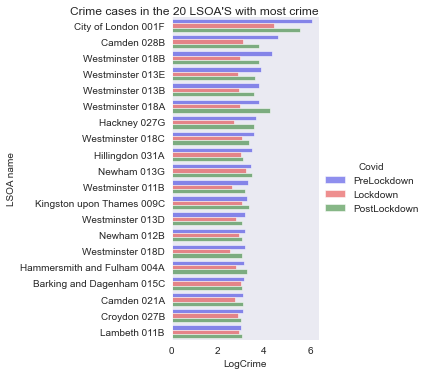

In [21]:
## Crime cases in 20 LSOAS with Most Crime
check_data = data[["Covid","LSOA name","Location","Crime"]].groupby(["Covid","Location",
    "LSOA name"]).count().fillna(0)
check_data.reset_index(inplace=True)
data_agg = check_data.groupby(['LSOA name']).sum()
cats = data_agg.sort_values(['Crime'],
                     ascending=False).head(20).reset_index()
data_agg = check_data[check_data["LSOA name"].isin(cats["LSOA name"].unique())]
data_agg["LSOA name"].cat.remove_unused_categories(inplace=True)
data_agg['LogCrime'] = np.log(data_agg['Crime']+1)
order = data_agg[data_agg.Covid == "PreLockdown"].groupby("LSOA name").\
        sum().sort_values("LogCrime",ascending=False)
p_3 = sns.catplot(y="LSOA name",x="LogCrime",hue="Covid", ci=None,
            kind="bar",data=data_agg, order=order.index.astype(str),
            alpha=0.5,  palette=["b", "r", "g"])
p_3.fig.suptitle("Crime cases in the 20 LSOA'S with most crime",y=1)
p_3

## Distribution of crime counts by type 

Text(0.5, 1.1, 'Boxen plots for all types of crime comparing time period')

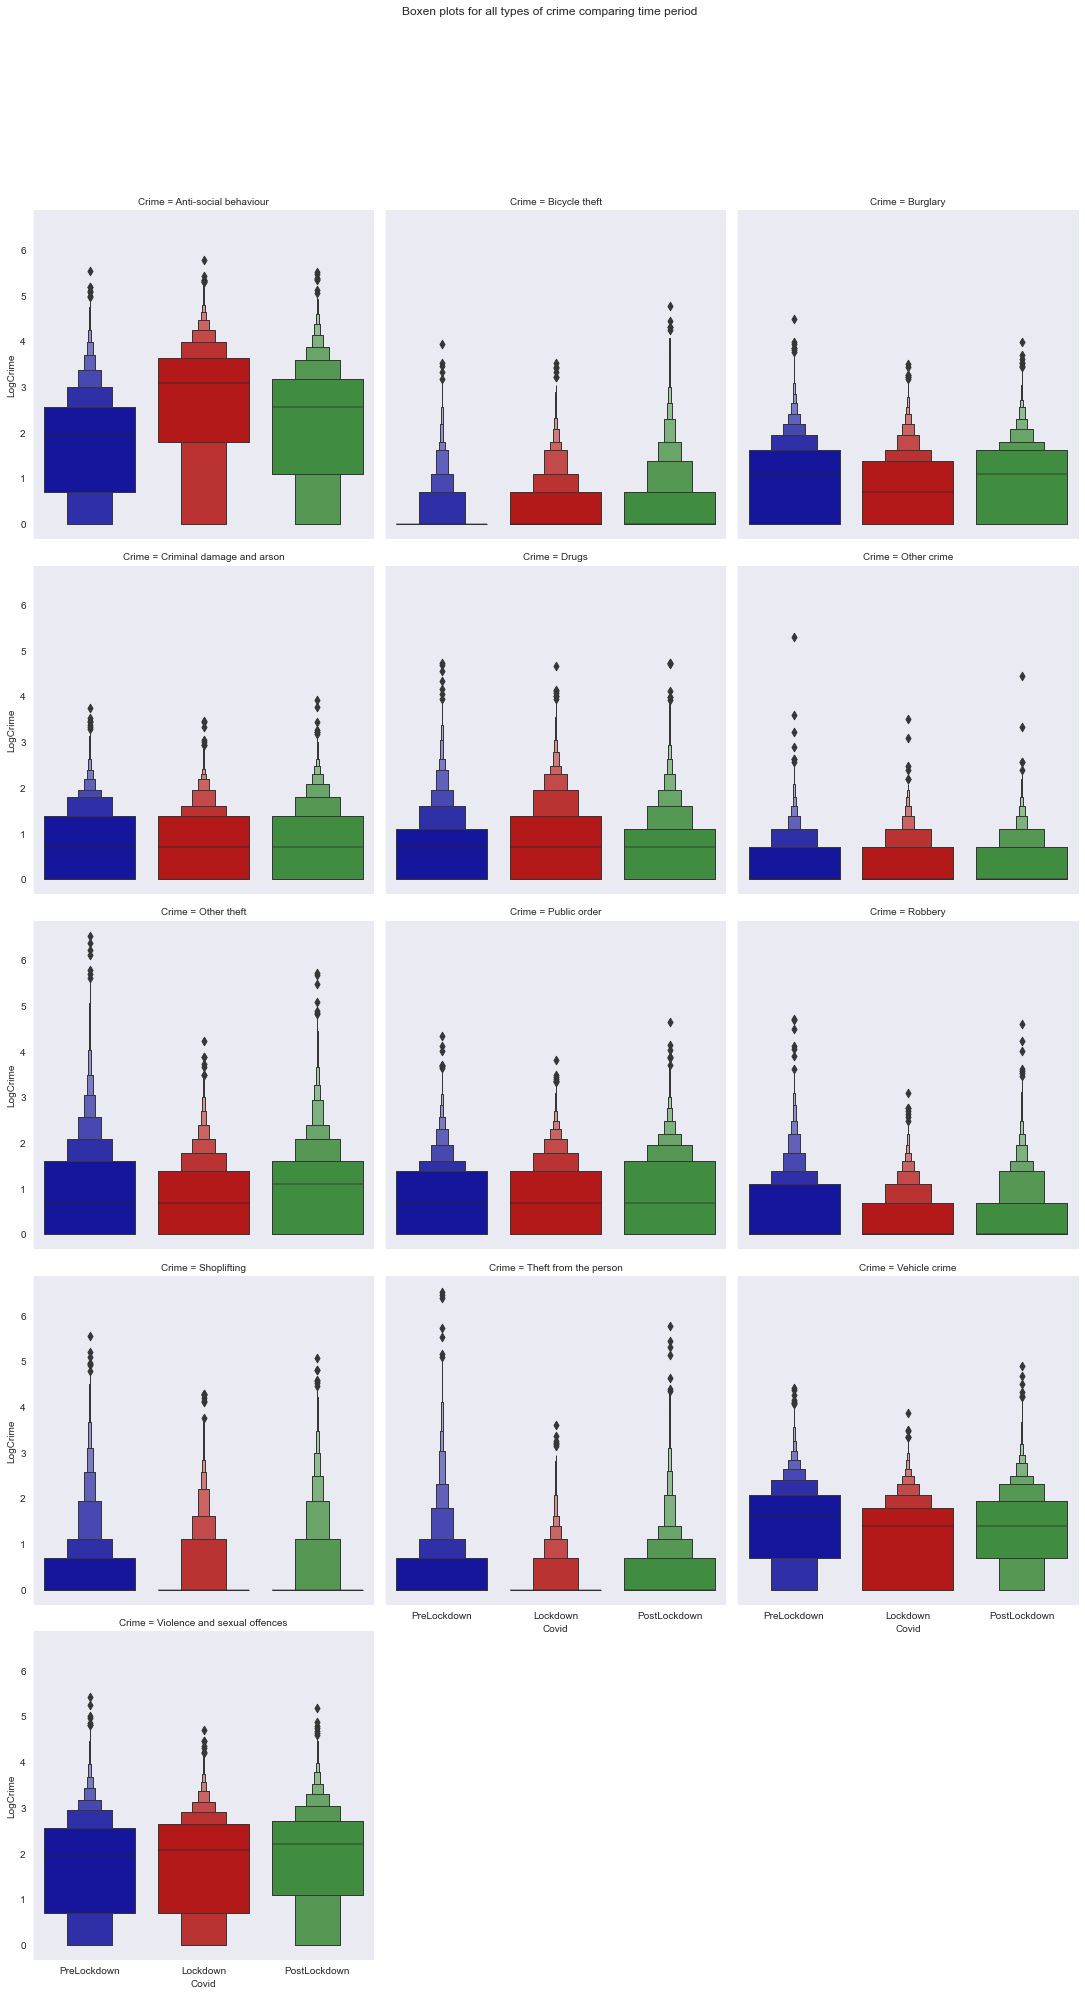

In [22]:
data_agg = data[["LSOA name", "Covid", "Crime", "Category"]].groupby(["LSOA name", "Covid", "Crime"]).count().fillna(0)
data_agg['LogCrime'] = np.log(data_agg['Category']+1)
data_agg.reset_index(inplace=True)

## Aggregating all Areas by Crime Type: Boxen
sns.set_palette(["#0000b3", "#cc0000", "#339933",])
p_5 = sns.catplot(x="Covid",y="LogCrime", col="Crime", kind="boxen",
            data=data_agg, col_wrap=3) 
p_5.fig.suptitle("Boxen plots for all types of crime comparing time period",y=1.1)

Several conclusions can be obtained from the boxen plots for the distribution of crimes by LSOA. 

- During lockdown there was a notorious increase in crimes related to *Anti-social behaviour* however it seems that the increase was stronger in certain LSOA's than others. Since the lower quantile extended when comparing with the other periods. 
- *Bicycle theft* cases increased consistently during the first nine months of 2020. The effect was seen in several LSOA's.
- Crimes related to theft such as *Burglary*, *Robbery*, *Other theft* and *Theft from the person* decreased during the lockdown period. However, they recovered in the Post Lockdown period. While it is true that cases of *Other theft* recovered during the third quarter of the year, we note that counts in high ocurrence LSOA's haven't been able to get back to Pre Lockdown levels. 
- *Drug* crimes increased during the lockdown period mostly in LSOA's that had low ocurrences. But the trend reverted and overall the cases were near their Pre Lockdown levels in the Post Lockdown.
- *Shoplifting* cases started to ocurr in LSOA's that had low cases in Pre Lockdown times the trend has remained even in Post Lockdown.
- During the Post Lockdown there was a notorious increase in *Violence and Sexual offences* in LSOA's that had low ocurrence of this type of crimes during the first semester of the year. 

### Criminal Outcomes

The figure below illustrates outcome categories for the different crime events analyzed in the sections above. We note that regarding the categories there doesn't seem to be any huge difference in the results when facetting by Pre, Post and regular Lockdown. Perhaps the only interesting difference is that less crimes were further investigated during the Lockdown period. Nevertheless, this difference just stems from the fact that more *Anti-social behaviour* crimes ocurred during this period. 

We note that no crimes that ocurred during Pre Lockdown times are still under investigation. However, there are lot of cases that ocurred during this period that have an unavailable court result. 

Text(0.5, 1.0, 'Crime Outcomes by period')

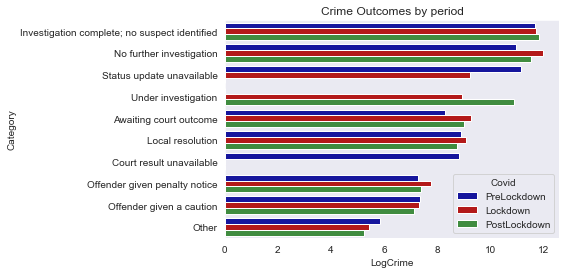

In [23]:
data_agg = data[["Covid", "Crime", "Category"]].groupby(["Covid","Category"]).\
            count().fillna(0).reset_index()

## Lump counts
counts = data_agg.groupby("Category").sum().sort_values("Crime",ascending=False)
data_agg["Category"] = np.where(data_agg.Category.isin(counts.index[-1:-7:-1]),
                                "Other", data_agg.Category)
## Aggregate and order
data_agg = data_agg.groupby(["Covid","Category"]).sum().reset_index()
data_agg["LogCrime"] = np.log(data_agg["Crime"]+1)
order = data_agg.groupby(["Category"]).sum().Crime.sort_values(ascending=False).index.astype(str)
p_6 = sns.barplot(x="LogCrime",y="Category", hue="Covid", order=order, data=data_agg)
p_6.set_title("Crime Outcomes by period")

## Maps by MSOA-Borough

In this section I research more on the geographical distribution of crime dynamics by plotting maps at both the MSOA and the Borough level. 

In [2]:
## Load Crime Data
data = pickle.load(open("Data/DataClean.p", "rb" ))

In [3]:
## Information on LSOA
data_LSOA = gpd.read_file("Data/LSOA/LSOA_2011_London_gen_MHW.shp")
data_LSOA = data_LSOA.to_crs(epsg=4326)

In [4]:
## Information on MSOA 
data_MSOA = gpd.read_file("Data/MSOA/MSOA_2011_London_gen_MHW.shp")
data_MSOA = data_MSOA.to_crs(epsg=4326)
data_MSOA.head()

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((-0.10414 51.50841, -0.10444 51..."
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((0.14809 51.59678, 0.14806 51.59640, ..."
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((0.15063 51.58306, 0.14838 51.58075, ..."
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,"POLYGON ((0.18508 51.56480, 0.18400 51.56391, ..."
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,"POLYGON ((0.14988 51.56807, 0.15076 51.56778, ..."


In [5]:
## Correspondence table between LSOA and MSOA 
match_table = data_LSOA[["LSOA11CD","MSOA11NM"]]

## Unique LSOA codes in police dataset
codes = data["LSOA code"].unique()
ids = pd.Series(codes).isin(match_table["LSOA11CD"])

## Codes that can't be matched:
## There are some weird codes but they don't seem to belong to London (drop them)
data[~data["LSOA code"].isin(codes[ids])]["LSOA name"].unique() 

## Keep data that can be matched with LSOA polygons
use_data = data[data["LSOA code"].isin(codes[ids])]
use_data = pd.merge(use_data, match_table, how="left", left_on=["LSOA code"], 
         right_on=["LSOA11CD"])


In [6]:
## Calculate counts that are going to appear in the map
ccounts = use_data[["MSOA11NM","Covid", "Crime"]].groupby(["MSOA11NM", "Covid"]).\
    count().fillna(0)
ccounts.reset_index(inplace=True)
ccounts["CrimeVariation(%)"] = ccounts.groupby("MSOA11NM").\
transform(lambda x: np.append([np.nan], 100*(np.log(x[1:].values)-np.log(x[:-1].values))))
ccounts["CrimeChange"] = ccounts[["MSOA11NM", "Crime"]].groupby("MSOA11NM").\
transform(lambda x: np.append([np.nan], (x[1:].values)-x[:-1].values))

## Merge geometry with counts
data_map = data_MSOA.merge(ccounts[ccounts.Covid != "PreLockdown"], how="right")
data_map.set_index(data_map.MSOA11CD, inplace=True)

## Get Georeference json to plot
geo_data = data_map[["geometry"]].__geo_interface__


In [1]:
## Plot JSON + Counts
fig = px.choropleth(data_map[["MSOA11CD","MSOA11NM","CrimeChange", "CrimeVariation(%)", "Covid"]], 
                    geojson=geo_data, locations = "MSOA11CD",  color='CrimeVariation(%)',
                    color_continuous_scale=px.colors.sequential.Blackbody[::-1], 
                    facet_col="Covid", hover_name="MSOA11NM",
                    hover_data ={'MSOA11CD':False, 'CrimeVariation(%)':':.2f',
                                 'CrimeChange':':.2f', 'Covid':False})
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title="Approximate variation in crimes by MSOA")
#fig.write_html("Mapa1.html")
#fig

NameError: name 'px' is not defined

The maps are colored at the MSOA level by the change in the logarithm of aggregate crime counts (approximate variation in cases). The left map compares the change between the Lockdown and Pre Lockdown levels while the second shows the change from the Post Lockdown levels to Lockdown. 

The image shows how crime counts sharply fell in the center of the city mostly in **Westminster** area and the **City of London** while they started increasing in the outskirts. Some of the most affected MSOA's by this crime absorption phenomena were **Hillingdon 05**, **Merton 025**, **Bromley 021** and **Havering 003**. 

When comparing the Post Lockdown and the Lockdown levels we note that crime increased again in the center of the city as well as in MSOA's near it. **Westminster** and the **City of London** had remarkable increases in crime counts. The **Kensigton and Chelsea** area also had a strong increase in criminal activity.

In [8]:
## Regular Expression to Get Name of the Borough
p = re.compile('[a-zA-Z ]+[a-z]')
use_data["Region"] = [p.match(x).group() for x in use_data.MSOA11NM.values]

## Counts by borough
counts = use_data[["MSOA11NM", "Region", "Covid"]].groupby(["Region", "Covid"]).count()
counts.reset_index(inplace=True)
counts["CrimeVariation(%)"] = counts.groupby("Region").\
transform(lambda x: np.append([np.nan], 100*(np.log(x[1:].values)-np.log(x[:-1].values))))
counts["CrimeChange"] = counts[["Region","MSOA11NM"]].groupby("Region").\
transform(lambda x: np.append([np.nan], (x[1:].values)-x[:-1].values))


In [9]:
## Read Polygons for Boroughs
data_boro = gpd.read_file("Data/Borough/London_Borough_Excluding_MHW.shp")
data_map_boro = pd.merge(data_boro, counts[counts.Covid != "PreLockdown"], left_on = "NAME", right_on = "Region")
data_map_boro = data_map_boro.to_crs(epsg=4326)

## Get Georeference json to plot
data_map_boro.set_index(data_map_boro.GSS_CODE, inplace=True)
geo_data = data_map_boro[["geometry"]].__geo_interface__

In [2]:
## Merge LSOA polygons with counts
fig = px.choropleth(data_map_boro[["NAME", "GSS_CODE", "CrimeVariation(%)", "Covid", "CrimeChange"]], 
                    geojson=geo_data, locations = "GSS_CODE",  color='CrimeVariation(%)',
                    color_continuous_scale=px.colors.sequential.Blackbody[::-1], 
                    facet_col="Covid", hover_name="NAME",
                    hover_data ={'GSS_CODE':False, 'CrimeVariation(%)':':.2f',
                                 'CrimeChange':':.2f', 'Covid':False})
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title="Approximate variation in crimes by Borough")
#fig.write_html("Mapa3.html")
fig

NameError: name 'px' is not defined

Looking at the maps at the Borough level we note one further regularity. While the Lockdown created a strong outflow of criminal activity from the city center to almost all other Boroughs, this dynamic reverted when the Lockdown was lifted. The crime rates for the Boroughs of **Kensington and Chelsea** and **Southwark** had increases in both periods. This suggests that the decrease in criminal activity in Zone 1 wasn't completely mirrored in Zone 2 locations. Hence this Zones ended up being affected since they had to face criminal case increases in both periods.

It would be interesting to make some similar maps to note if the conclusion changes when we condition on the type of Crime. Its highly probable that some of the conclusions are mainly driven by the *Anti-social behaviour* crime given its relatively high frequency. 

### Has the relation between the number of crimes and searches changed?

In this section I use the search event data to check if there was any change in the number of frisks the police did with respect to the total number of crimes during the Lockdown period. 

In [11]:
## Load Data 
data = pickle.load(open("Data/DataClean.p", "rb" ) )

## Load Data for frisk
data_frisk = pickle.load(open("Data/AllFrisk.p", "rb" ))

## Aggregate frisk counts by MSOA and Covid Period
data_frisk.Month = data_frisk.Month.astype(int)
conds = [data_frisk.Month.lt(4), data_frisk.Month.lt(7), data_frisk.Month.lt(10)]
data_frisk['Covid'] = np.select(conds, ["PreLockdown","Lockdown","PostLockdown"])
data_frisk.drop(["Month"], axis=1, inplace=True)
data_frisk = pd.melt(data_frisk, id_vars = ["MSOA11NM", "Covid"])
merge_frisk = data_frisk.groupby(["MSOA11NM","Covid"]).sum().reset_index()

## Load data on MSOA 
data_LSOA = gpd.read_file("Data/LSOA/LSOA_2011_London_gen_MHW.shp")
data_LSOA = data.merge(data_LSOA[["LSOA11CD","MSOA11NM"]],left_on="LSOA code", right_on="LSOA11CD")
data_LSOA.drop(["LSOA name", "LSOA11CD"], axis=1, inplace = True)
data_LSOA.rename({"MSOA11NM":"MSOA name"}, inplace = True, axis = 1)

Text(0.5, 1.0, 'Relation between frisk counts and crime')

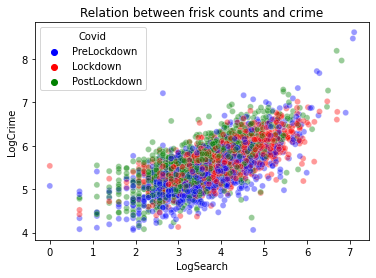

In [12]:
## Crime counts by LSOA
data_agg = data_LSOA[["Covid", "MSOA name", "Crime", "Category"]].groupby(
    ["Covid","MSOA name", "Crime"]).count().fillna(0)

## Merge with frisk data
use_data = pd.merge(data_agg.reset_index().groupby(["MSOA name", "Covid"]). \
                    sum().reset_index(), 
            merge_frisk, left_on = ["MSOA name", "Covid"], 
            right_on = ["MSOA11NM", "Covid"])

## Logarithm
use_data["LogCrime"] = np.log(use_data["Category"] + 1)
use_data["LogSearch"] = np.log(use_data["value"] + 1)
use_data.drop(["MSOA11NM", "value", "Category"], axis=1 ,inplace=True)

p_sc = sns.scatterplot(data=use_data, x="LogSearch", y="LogCrime", hue="Covid",
            alpha=0.4, palette=["b", "r", "g"])
p_sc.set_title("Relation between frisk counts and crime")

The figure above shows that the relation between frisks and crime cases is linear in the log-log scale. Its important to mention that there doesn't seem to be any evidence that the relation changed when comparing the three periods. Rater it appears that it remained relatively stable. 

## Data modelling

In this section I intend to use some matrix clustering procedure and a factorial method to gain further insight on how to group similar LSOA's according to their crime counts in order to learn more about the underlying structures in crime composition. 

### Matrix Clustering

In [13]:
## Information on MSOA 
data_LSOA = gpd.read_file("Data/LSOA/LSOA_2011_London_gen_MHW.shp")
data_LSOA = data.merge(data_LSOA[["LSOA11CD","MSOA11NM"]], left_on="LSOA code", right_on="LSOA11CD")
data_LSOA.drop(["LSOA name", "LSOA11CD"], axis=1, inplace = True)
data_LSOA.rename({"MSOA11NM":"MSOA name"}, inplace = True, axis = 1)

## Crime counts by LSOA
data_agg = data_LSOA[["Covid", "MSOA name", "Crime", "Category"]].groupby(
    ["Covid","MSOA name", "Crime"]).count().fillna(0)
data_agg.head(30)

Category
Covid       MSOA name                Crime                                 
PreLockdown Barking and Dagenham 001 Anti-social behaviour             35.0
                                     Bicycle theft                      1.0
                                     Burglary                          22.0
                                     Criminal damage and arson         17.0
                                     Drugs                              4.0
                                     Other crime                        4.0
                                     Other theft                       17.0
                                     Public order                       8.0
                                     Robbery                            6.0
                                     Shoplifting                        1.0
                                     Theft from the person              0.0
                                     Vehicle crime                     20.0
                                     Violence and sexual offences      53.0
            Barking and Dagenham 002 Anti-social behaviour             56.0
                                     Bicycle theft                      0.0
                                     Burglary                          25.0
                                     Criminal damage and arson         17.0
                                     Drugs                              8.0
                                     Other crime                        5.0
                                     Other theft                       20.0
                                     Public order                      10.0
                                     Robbery                           17.0
                                     Shoplifting                        6.0
                                     Theft from the person              1.0
                                     Vehicle crime                     65.0
                                     Violence and sexual offences      81.0
            Barking and Dagenham 003 Anti-social behaviour             25.0
                                     Bicycle theft                      0.0
                                     Burglary                           7.0
                                     Criminal damage and arson          8.0

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_samples, silhouette_score
##-------------------------------------------------------------------##
def seriation(x):
    """ Takes similarity matrix returns permutation asociated to
    fiedler eigenvector """
    ## Build Laplacian
    L = np.diag(np.sum(x,1)) - x
    # Eigenvalues/Eigenvectors sorted
    D, V = np.linalg.eigh(L)
    eig_orders = np.argsort(D)
    fied_vector = V[:,eig_orders[1]]
    # Reorder according to the fiedler eigenvector
    return np.argsort(fied_vector)

## Cut
def cut_mat(x, cut, index):
    """ Takes ordered similarity matrix returns a clustering assignment
    using the cut value"""
   # pdb.set_trace()
    clust_save = []
    cond = True
    while cond:
        fr = x[:,0]
        try:
            ind = np.where(fr < cut)[0][0]
        except: 
            ind = x.shape[0]
        clust_names = index[:ind]
        index = index[ind:]
        x = x[ind:,ind:]
        cond = (x.shape[0]) > 1
        clust_save.append(clust_names)
    if len(index) == 1:
        clust_save.append(index)
    return clust_save

## Auxiliary functions to cluster
def get_data(data_agg, period):
    """Takes the dataset with counts filter by period and calculate the 
    cosine similarity between LSOA, creates clusters according to the matrix 
    ordered by the fiedler eigenvector"""
    
    data_aux = data_agg[data_agg.index.get_level_values(0) == period].reset_index()
    data_aux.drop(["Covid"],axis = 1, inplace=True)
    data_aux = data_aux.pivot("MSOA name", "Crime")
    
    ## Data without LSOA no crime
    MSOA = list(data_aux.index)
    
    ## Similarity
    data_cos = cosine_similarity(data_aux.to_numpy())
    
    ## Cluster: Seriation as in class
    f_perm = seriation(data_cos)
    cos_mat_ser = data_cos[f_perm,:]
    cos_mat_ser = cos_mat_ser[:,f_perm]
    return cos_mat_ser, f_perm, MSOA, data_aux

def get_cluster_sil(th, cos_mat_ser, f_perm, MSOA, data_pre):
    """ Given a threshold generates clusters from the result of the 
    seriation procedure using a predefined cut function. Calculates Silhouette
    score of the clustering assignment"""
    ## Matrix to cut 
    my_mat = cos_mat_ser.copy()
    cut_index = [MSOA[i] for i in f_perm]
    clusters = cut_mat(my_mat, th, cut_index)
    
    ## Cluster assignments
    cluster_assign = [index for name in MSOA for index, 
                      cluster in enumerate(clusters) if name in cluster]
    assignments = pd.DataFrame({"MSOA name":MSOA, 
                                "Cluster":cluster_assign})
    
    ## Final Clusters
    assignments.sort_values("MSOA name", inplace=True)
    
    ## Slihouette
    try:
        metric = silhouette_score(data_pre.to_numpy(), list(assignments["Cluster"]))
    except:
        metric = -1
    return metric, assignments

##-------------------------------------------------------------------------------##

In [15]:
## Data for PreLockdown period is used to generate initial clusters
data_use = get_data(data_agg,"PreLockdown")    

## Choice Cluster threshold
grid = np.arange(0.2,0.9,step=0.05)
sil_vals = [get_cluster_sil(x, *data_use)[0] for x in grid]
choice = grid[np.argmax(sil_vals)]

## Create clusters
_, cluster = get_cluster_sil(choice,*data_use)
cluster.Cluster.value_counts()

1    960
0     18
2      5
Name: Cluster, dtype: int64

I took the counts for each crime in the respective LSOA's during the PreLockdown period and calculated a similarity matrix based on this information. I ordered the similarity matrix based on the fiedler eigenvector and created clusters by thresholding at a given value of similarity. The formed groups have the property that the similarity between the first member and the last is above the chosen threshold.

I made these cluster assignments for several threshold values and ultimately chose the best one based on the silhouette value of the assignment. 


<AxesSubplot:title={'center':'Silhouette Plot'}, xlabel='Cut Value', ylabel='Silhouette'>

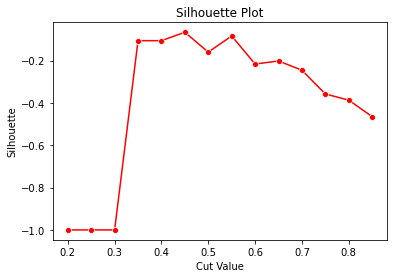

In [16]:
p_s = sns.lineplot(x = "Cut Value", y = "Silhouette", 
             data = pd.DataFrame({"Cut Value" : grid, "Silhouette" : sil_vals}),
             marker = "o", color = "r")
p_s.set_title("Silhouette Plot")
p_s

Given the results of the silhouette for the different thresholds I took 0.45 as the cut point for the initial cluster assignments. 

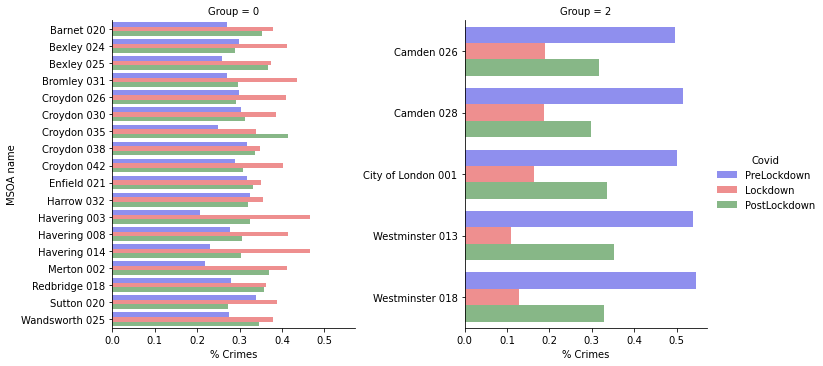

In [17]:
## Check MSOA's in low sized clusters
check_MSOA = cluster[cluster.Cluster.isin([0,2])]
data_plot = data_agg[data_agg.index.get_level_values(1). \
                     isin(check_MSOA["MSOA name"])].reset_index()
data_plot = data_plot.groupby(["MSOA name","Covid"]).agg(sum).reset_index()

## Normalize by total crimes ocurred in the MSOA 
data_total = data_plot.groupby("MSOA name").agg(sum).reset_index()
data_plot = data_plot.merge(data_total, on="MSOA name")
data_plot["% Crimes"] = data_plot.Category_x/data_plot.Category_y

## Add Cluster Info
data_plot = data_plot.merge(check_MSOA)
data_plot.rename({"Cluster":"Group"},axis=1,inplace=True)

p = sns.catplot(y="MSOA name",x="% Crimes",hue="Covid", col="Group",
                ci=None, kind="bar",data=data_plot, alpha=0.5, 
                sharey=False, palette=["b", "r", "g"])
p

Based on the cluster assignments obtained through the chosen threshold, we see that the procedure separates a group of MSOA's in which crime counts dropped significantly during the Lockdown and another in which counts increased sharply during this period. The first group includes several MSOA's located in the center of the city. The characterizing trait for this group is that crime fell during Lockdown and rose in the Post Lockdown period. However, the increase wasn't enough to get the crime counts to Pre Lockdown levels. 

For the second group we note that it is composed of MSOA's in which crime counts increased sharply during the Lockdown period. It seems that for most of the MSOA's the increase in crime counts was temporary and the criminal activity reverted to Pre Lockdown numbers as soon as the Lockdown ended. However, there are certain excepctions to this pattern namely, **Bexley 025**, **Croydon 035**, **Merton 002**, among others. 

The result is interesting because it was obtained based only on Pre Lockdown crime counts. What this means is that the crime structure between this two groups was at the onset very different. It is easy to see (by checking the original data) that in fact the MSOA's in group 2 are characterized by a high count of crimes related to theft, this includes *Burglary*, *Theft from the person* and other types of theft which were precisely the crimes that fell the most during the Lockdown period precisely due to the stay at home orders. 

On the other hand group 0 LSOA's are characterized by high crime counts of *Vehicle Crimes* and *Violence and sexual offences* the latter is one of the crimes that increased the most during the first three quarters of the year. 


### Multiple Correspondence Analysis

In this case since I am interested in the relation of a categorical variable (namely **epoch**, defined as Pre Lockdown, Lockdown and Post Lockdown) to a set of continuous variables I can't use traditional dimension reduction methods because I would lose the variable I am most interested in. Hence, to face this problem I decided to bin the continuous variables and carried out a Multiple Correspondence Analysis. 

In [20]:
## Load Data
data = pickle.load(open("Data/DataClean.p", "rb" ) )

# Information LSOA|MSOA
data_LSOA = gpd.read_file("Data/LSOA/LSOA_2011_London_gen_MHW.shp")
data_LSOA = data.merge(data_LSOA[["LSOA11CD","MSOA11NM"]],left_on="LSOA code", right_on="LSOA11CD")
data_LSOA.drop(["LSOA name", "LSOA11CD"], axis=1, inplace = True)
data_LSOA.rename({"MSOA11NM":"MSOA name"}, inplace = True, axis = 1)

## Crime counts by MSOA
data_agg = data_LSOA[["Covid", "MSOA name", "Crime", "Category"]].groupby(
    ["Covid","MSOA name", "Crime"]).count().fillna(0).reset_index()
data_agg = pd.pivot(data_agg, index=["MSOA name", "Covid"], columns = "Crime",
         values = "Category")

## Binning variables
def cut_fun(x):
    q_vals = x.quantile([0, 0.4, 0.8, 1]).values
    return pd.cut(x, bins = q_vals, labels = ["Low", "Medium", "High"])

data_MCA = data_agg.transform(cut_fun)
data_MCA_use = data_MCA.reset_index()
data_MCA_use.drop(["MSOA name"], axis=1, inplace=True)

In [22]:
## Multiple Correspondence Analysis 
import prince as pr
mca = pr.MCA(n_components=14, n_iter=5, copy=True, 
             check_input=True, engine='auto', random_state=42)
mca = mca.fit(data_MCA_use)

## Get column|row coordinates 
var_reps = mca.column_coordinates(data_MCA_use)
row_reps = mca.row_coordinates(data_MCA_use)
row_reps.rename({0:"x", 1:"y"}, axis = 1, inplace = True)

In [23]:
## Construct new variables to plot
new_col = [x.split("_") for x in var_reps.index]
intensity = [x[1] for x in new_col]
intensity[:3] = ["Low", "Medium", "High"]
var_name = [x[0] for x in new_col]

## Dataframe to be plotted
new_mat = pd.concat([var_reps.reset_index(), 
                     pd.DataFrame({"Type" : var_name, "Intensity" : intensity})], 
          axis = 1)
new_mat.drop(["index"], axis = 1, inplace = True)
new_mat.rename({0:"x", 1:"y"}, axis = 1, inplace = True)

<AxesSubplot:title={'center':'Variable projections on the first two principal axes'}, xlabel='x', ylabel='y'>

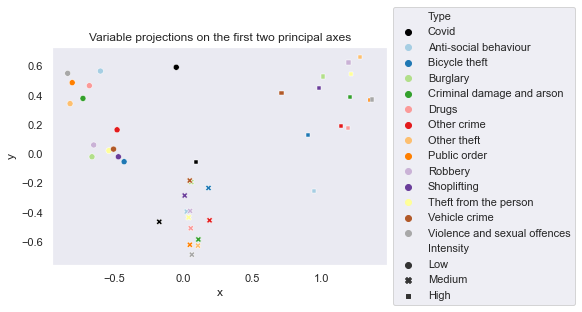

In [26]:
## Principal Axis plot
my_palette = [(0,0,0)]
my_palette.extend(sns.color_palette("Paired"))
my_palette.extend([(0.66, 0.66, 0.66)])
sns.set_theme(style = "dark")
fig = sns.scatterplot(data = new_mat[["Type", "Intensity", "x" , "y"]], x = "x",
                y = "y" , hue = "Type", style ="Intensity", 
                palette = my_palette)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_title("Variable projections on the first two principal axes")
fig

Text(0.5, 1.0, "MSOA's projections on the first two principal axes")

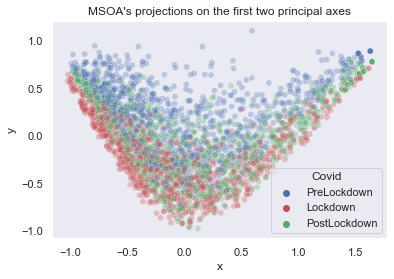

In [27]:
## Get row coordinates
row_reps = mca.row_coordinates(data_MCA_use)
row_reps.rename({0:"x", 1:"y"}, axis = 1, inplace = True)

## Plot
names = pd.DataFrame({"MSOA name" : data_MCA.index.get_level_values(0),
                     "Covid" : data_MCA.index.get_level_values(1)})
data_row = pd.concat([names, row_reps[["x","y"]]], axis = 1)
fig_ind = sns.scatterplot(x = "x", y = "y" ,data = data_row, hue = "Covid",
                alpha = 0.3, palette = ["b", "r", "g"])
fig_ind.set_title("MSOA's projections on the first two principal axes")

The first figure above shows the projection of the variables in the factorial space. We note that the first factorial axis separates low, medium and high counts of the different crimes. The left part of the axis is related to low counts in any of the categories while the right part is related to high ones. The second factorial axis creates a separation between Pre Lockdown times (coded as Low intensity) and Lockdown|PostLockdown (coded as Medium and High intensity respectively). We note that the separation obtained in the crime variables is better than the one obtained in the periods.  

- There is evidence that in Pre Lockdown times there were mostly two types of criminal activity. The first one related to minor offences with usually low counts such as *Public order*, *Anti-Social behavior*, *Drugs*, *Criminal damage and arson* and *Violence and sexual offences* coexisting in MSOA's away from the center of the city. The second type of criminal activity was the one related to busy MSOA's in the center of the city and it consisted of high counts of theft including *Robbery*, *Theft from the person* and *Other theft*.  
- Vehicle crimes were seen more often during PreLockdown times but ocurred with no apparent relation to other types of crime at the MSOA level. There is a slight evidence that certain MSOA's had public order problems in Pre Lockdown times, these cases appear to be associated with high counts in the *Public order*, *Robbery* and *Criminal damage and arson* categories that ocurred simultaneously. 
- Lockdown times were related to moderate ocurrence of cases related with theft. This is probably a reflection of the decrease in cases of these crimes that ocurred in the MSOA's located in the city center. Furthermore, Lockdown was related to moderate counts of *Violence and sexual offences* along with *Public Order* and *Criminal Damage and Arson*. Moderate counts of *Drugs* and *Anti-social behavior* also characterize the Lockdown times.
- Post Lockdown times are related with moderate counts of *Vehicle Crimes* as well as *Bicycle thefts* these two appear to be associated. Apparently high counts of *Anti-social behaviour* are more related with the Post Lockdown period rather than the others. 
- Finally, there doesn't appear to be any strong evidence that low crime counts in *Theft from the person*, *Vehicle Crimes*, *Robbery* and *Burglary* are more associated to any of the periods that ocurred during the year. This suggests that MSOA's that started with low counts in this type of criminal activity the year remained almost changeless through the imposition of the Lockdown and its posterior lift. 

## Conclusion

Overall we can make the following characterization of the crime composition in the three periods considered. During the Pre Lockdown period there was an important contribution of geographical aggregations located in the city center where crimes related to general forms of theft ocurred frequently. The introduction of the lockdown disrupted the inflow of people in the city center (both conmuters and tourists) this was apparently associated with a notorious decrease in theft cases and at the macrolevel a general reduction in criminal activity in Boroughs such as the City Of London and Westminster. 

During the Lockdown the sharp decrease in theft was reflected by a less amount of cases being handled by the City Of London police force and a higher proportion received by the Metropolitan Service Force. There was a very strong increase in cases of Anti social behaviour and a relatively moderate one in Drug crimes. The ocurrence of these crimes was more related to peripheral areas rather than the city center. 

After the end of the Lockdown there was a new surge of criminal activity in the city center and notable recover of counts related with general forms of theft in this location. Probably related with the increase in the flow of conmuters and general public. Drug crimes and Anti Social behaviour related ocurrences also fell in the Post Lockdown though the latter remained above its historical levels (when comparing with the first quarter of the year). However, the Post Lockdown period also showed an alarming increase in crimes related with Violence and Sexual offences which should be investigated further.   

Overall this crime composition changes seem to have had worsened the situation in some Zone 2 geographical aggreations that experiment increases both when comparing the Lockdown period with the Pre Lockdown and the Post Lockdown with the former one. There was a steady increase in Bicycle Theft cases since the introduction of the Lockdown this trend consolitade during the last quarter of the year. Finally, there wasn't any apparent change in the number of search procedures carried by the police during the year with respect to the crime counts. 